In [1]:
# general purpose libraries
import numpy as np
import datetime as dt
import pandas as pd
import os
import warnings
import pickle
from timeit import default_timer as timer
from collections import OrderedDict
from itertools import chain

from tqdm.notebook import tqdm
from scipy.signal import hilbert

pd.set_option("display.max_columns", None)


import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )


In [2]:
# plots and visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as ply_go
import plotly.figure_factory as ply_ff
import plotly.colors as ply_colors #.sequential.Oranges as orange_palette
#print(plotly.colors.named_colorscales() )
#plotly.colors.sequential.swatches()
#ply_colors.sequential.Oranges

In [3]:
# DSP libraries
from scipy import signal
import librosa
import librosa.display as librosa_display

In [4]:
# ML and data modelling libraries
from sklearn.preprocessing   import MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, precision_recall_curve,confusion_matrix,precision_score, recall_score,average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

In [5]:
### Setup paths and directories
work_dir = r'dataset/' 
data_dir = work_dir + r"COUGHVID/"
raw_data_dir = data_dir + r"raw/"
audio_outdir = "out"

metadata_file = "metadata_compiled.csv"

In [6]:
metadata=pd.read_csv(data_dir+metadata_file,sep=",")
#print(metadata.columns)

# convert strings 'True'/'False' to genuine booleans
cols_to_boolean = (['respiratory_condition', 'fever_muscle_pain',
                     'dyspnea_1', 'wheezing_1', 'stridor_1','choking_1', 'congestion_1', 'nothing_1',
                     'dyspnea_2', 'wheezing_2', 'stridor_2','choking_2', 'congestion_2', 'nothing_2',
                     'dyspnea_3', 'wheezing_3', 'stridor_3','choking_3', 'congestion_3', 'nothing_3',
                     'dyspnea_4', 'wheezing_4', 'stridor_4','choking_4', 'congestion_4', 'nothing_4'])
for c in cols_to_boolean:
    metadata.loc[metadata[c].notnull(),c] = metadata.loc[metadata[c].notnull(),c].astype(bool) 

# remove entries where either status or age is NA
print("Metadata df entries before cleaning NAs: {}".format(metadata.shape[0]))
metadata = metadata.loc[~((metadata['status'].isnull() ) | (metadata['age'].isnull()) ),]
print("Metadata df entries after cleaning NAs: {}".format(metadata.shape[0]))



Metadata df entries before cleaning NAs: 27550
Metadata df entries after cleaning NAs: 15218


In [37]:
metadata['audio_class'] = 'X' # default, we should have none by the end of this classification process
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['status'] == "COVID-19") ,'audio_class'] = 1
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['status'] == "healthy") ,'audio_class'] = 0
# metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['status'] == "symptomatic") ,'audio_class'] = 0

print("Entries subdivided in classes. Printing the number of entries for each class:")
print(metadata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

print("\n\n\nSplitting count by class and status:")
print(metadata[['audio_class','status','uuid']].groupby(['audio_class','status']).count().rename(columns={'uuid':'N_entries'}) )


Entries subdivided in classes. Printing the number of entries for each class:
             N_entries
audio_class           
0                 7905
1                  608
X                 6705



Splitting count by class and status:
                         N_entries
audio_class status                
0           healthy           7905
1           COVID-19           608
X           COVID-19           357
            healthy           3827
            symptomatic       2521


In [38]:
validdata = metadata.loc[(metadata['audio_class'] != 'X')]
print(validdata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                 7905
1                  608


In [39]:
# Balance the number of each classes
num = len(validdata.loc[validdata["audio_class"] == 1])
balanced_data = pd.concat([
    validdata.loc[validdata["audio_class"] == 1],
    validdata.loc[validdata["audio_class"] == 0].sample(n = num)
])

In [40]:
print(balanced_data[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                  608
1                  608


In [12]:
signalLength = []
srs = []

for uuid in tqdm(balanced_data["uuid"].values):
    filename = uuid + ".webm"
    if not os.path.exists(raw_data_dir + filename):
        # try to look for a .ogg file
        filename = uuid + ".ogg"
        if not os.path.exists(raw_data_dir + filename):
            print(f"could not find audio file for uuid: {uuid}")
            continue

    file_path = os.path.join(raw_data_dir, filename)
    # print(file_path)
    signal, sr = librosa.load(file_path, sr = None)
    signalLength.append(signal.shape[0])
    srs.append(sr)

  0%|          | 0/1216 [00:00<?, ?it/s]

dataset/COUGHVID/raw/015576c8-2b03-4dcb-b251-78a984fe86fe.webm
dataset/COUGHVID/raw/0177b817-0ba3-498a-bc05-48bc66cc91b8.webm
dataset/COUGHVID/raw/01820f7c-b953-4faf-aa13-978cfda6b08e.webm
dataset/COUGHVID/raw/01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7.webm
dataset/COUGHVID/raw/02aa80ef-a83b-477f-b01d-575651364b22.webm
dataset/COUGHVID/raw/031fd54a-87b5-4223-9af6-60985127fb7a.webm
dataset/COUGHVID/raw/033da4e3-7365-4adc-9252-7347816e4e77.webm
dataset/COUGHVID/raw/0379c586-c500-483c-83a6-95b63afe6931.webm
dataset/COUGHVID/raw/03d30b8b-03f8-4089-bda8-0e14deec7d82.webm
dataset/COUGHVID/raw/0640716b-e287-4181-a653-5b798e8308c8.webm
dataset/COUGHVID/raw/06b568b5-b9f8-4334-816c-c16009bb5de7.webm
dataset/COUGHVID/raw/06b58ff7-42e9-49d8-8b56-dd82e7b18ace.webm
dataset/COUGHVID/raw/0762cd0a-5ce6-4b1b-9374-5d4396c218ed.webm
dataset/COUGHVID/raw/080b6119-f1ab-4337-93dd-aaccf73b4ee1.webm
dataset/COUGHVID/raw/082991fb-ee66-4970-91dd-50890f4cc9b1.webm
dataset/COUGHVID/raw/09115490-33a9-461c-9437-d7f71be057

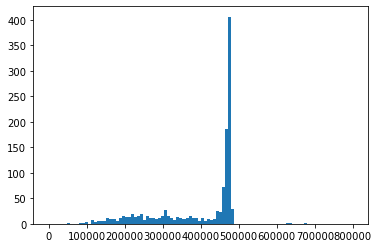

In [14]:
_ = plt.hist(np.asarray(signalLength), bins = 100, range = (0, 8e5))

In [19]:
signalLength = np.asarray(signalLength)
(signalLength < 5e5).sum() / signalLength.size

0.9975328947368421

In [21]:
mfccs = []

for uuid in tqdm(balanced_data["uuid"].values):
    filename = uuid + ".webm"
    if not os.path.exists(raw_data_dir + filename):
        # try to look for a .ogg file
        filename = uuid + ".ogg"
        if not os.path.exists(raw_data_dir + filename):
            print(f"could not find audio file for uuid: {uuid}")
            continue

    file_path = os.path.join(raw_data_dir, filename)
    print(file_path)
    signal, sr = librosa.load(file_path, sr = None)

    signal = librosa.util.fix_length(signal, 500000)
    mfcc = librosa.feature.mfcc(signal, n_mfcc=15, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    mfccs.append(mfcc)

  0%|          | 0/1216 [00:00<?, ?it/s]

dataset/COUGHVID/raw/015576c8-2b03-4dcb-b251-78a984fe86fe.webm


<ipython-input-21-9c80c0af85fa>:16: FutureWarning: Pass size=500000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal = librosa.util.fix_length(signal, 500000)
<ipython-input-21-9c80c0af85fa>:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal, n_mfcc=15, n_fft=2048, hop_length=512)


dataset/COUGHVID/raw/0177b817-0ba3-498a-bc05-48bc66cc91b8.webm
dataset/COUGHVID/raw/01820f7c-b953-4faf-aa13-978cfda6b08e.webm
dataset/COUGHVID/raw/01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7.webm
dataset/COUGHVID/raw/02aa80ef-a83b-477f-b01d-575651364b22.webm
dataset/COUGHVID/raw/031fd54a-87b5-4223-9af6-60985127fb7a.webm
dataset/COUGHVID/raw/033da4e3-7365-4adc-9252-7347816e4e77.webm
dataset/COUGHVID/raw/0379c586-c500-483c-83a6-95b63afe6931.webm
dataset/COUGHVID/raw/03d30b8b-03f8-4089-bda8-0e14deec7d82.webm
dataset/COUGHVID/raw/0640716b-e287-4181-a653-5b798e8308c8.webm
dataset/COUGHVID/raw/06b568b5-b9f8-4334-816c-c16009bb5de7.webm
dataset/COUGHVID/raw/06b58ff7-42e9-49d8-8b56-dd82e7b18ace.webm
dataset/COUGHVID/raw/0762cd0a-5ce6-4b1b-9374-5d4396c218ed.webm
dataset/COUGHVID/raw/080b6119-f1ab-4337-93dd-aaccf73b4ee1.webm
dataset/COUGHVID/raw/082991fb-ee66-4970-91dd-50890f4cc9b1.webm
dataset/COUGHVID/raw/09115490-33a9-461c-9437-d7f71be057b0.webm
dataset/COUGHVID/raw/09126c08-5214-4723-94f1-7b654464ea

<ipython-input-21-9c80c0af85fa>:17: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.1035156e-05
 -6.1035156e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal, n_mfcc=15, n_fft=2048, hop_length=512)


dataset/COUGHVID/raw/1fcd577a-af2b-4352-a735-a1d1a7e7d0b1.webm
dataset/COUGHVID/raw/1fd4bd15-88c4-47ae-bbe3-2434af431df5.webm
dataset/COUGHVID/raw/2018bfea-0071-4aca-8d45-18dac4d65199.webm
dataset/COUGHVID/raw/20602da6-a92f-40ad-81d2-1688f5f1fcde.webm
dataset/COUGHVID/raw/2089c2bd-d408-429e-9f15-138343a5cc9c.webm
dataset/COUGHVID/raw/21ad6bc4-ecc4-4a22-b940-618bdd7ad20b.webm
dataset/COUGHVID/raw/21aee478-6d13-45ea-be4d-4f29fd244798.webm
dataset/COUGHVID/raw/21d95211-da92-44a9-83c7-30f8d4c6d670.webm
dataset/COUGHVID/raw/22cb791b-2eba-480f-9eb3-69018bd25a04.webm
dataset/COUGHVID/raw/22dcfcdd-52a8-4b42-9c50-c0a3696382a9.webm
dataset/COUGHVID/raw/23180623-c32f-4fa7-85db-2aaf72438824.webm
dataset/COUGHVID/raw/23ad16a0-1a5b-4dfc-b326-f916f31fafe3.webm
dataset/COUGHVID/raw/240021ec-048e-431d-9548-11d7c234389e.webm
dataset/COUGHVID/raw/2475fcc6-74d7-46b8-b35b-4f134d7d57bc.webm
dataset/COUGHVID/raw/2561c0c9-c4d4-4d63-8c8a-610d6eafe593.webm
dataset/COUGHVID/raw/259ecdd2-5641-4b33-966d-7cf0b3af87

<ipython-input-21-9c80c0af85fa>:17: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00039673 -0.00036621
 -0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal, n_mfcc=15, n_fft=2048, hop_length=512)


dataset/COUGHVID/raw/dfa5dfd7-4af3-4d6c-83f1-51183f517d72.webm
dataset/COUGHVID/raw/ce29aef9-0a86-42e6-ab49-258b8a6b1a5e.webm
dataset/COUGHVID/raw/984cb71c-3e07-49a3-ae36-3e79933a2f40.webm
dataset/COUGHVID/raw/fb8ea05a-e6fc-4083-bfb9-a045fbe89413.webm
dataset/COUGHVID/raw/a88ba51c-d14f-49f1-9a2e-813efd3935e0.webm
dataset/COUGHVID/raw/6cadbc41-4119-46b9-8d8e-ee512bfacfa4.webm
dataset/COUGHVID/raw/94d4711d-3ac6-43c0-836f-9315f22b556f.webm
dataset/COUGHVID/raw/14ec33eb-2f22-431b-97fb-6e1c05a3d076.webm
dataset/COUGHVID/raw/5b3b1fd8-70c2-4b40-b759-e2cad6fe9a97.webm
dataset/COUGHVID/raw/a2f67e3d-47c2-4680-a09d-5355a3f99276.webm
dataset/COUGHVID/raw/d3261b1a-29fc-483f-ada5-293742233497.webm
dataset/COUGHVID/raw/ba0b781b-1243-4040-8393-74dd5019c27d.webm
dataset/COUGHVID/raw/833d3cd1-b5c0-45dd-96a8-120b43fa371c.webm
dataset/COUGHVID/raw/e6788288-778c-46d3-9d83-c4c2eb6f707d.webm
dataset/COUGHVID/raw/3e80334d-1d97-4dc5-a17a-affd1f06011e.webm
dataset/COUGHVID/raw/0e9aaad1-7459-46b4-8afa-e5716c4536

<ipython-input-21-9c80c0af85fa>:17: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.08728027 -0.00268555
  0.0559082 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal, n_mfcc=15, n_fft=2048, hop_length=512)


dataset/COUGHVID/raw/80411c72-2727-40a3-a781-0d71f1bb717d.webm
dataset/COUGHVID/raw/bfa98b9a-429d-43d3-beaa-34eb499ffa60.ogg
dataset/COUGHVID/raw/864e1796-6fcb-4b60-b79b-b103c5a49729.webm
dataset/COUGHVID/raw/6e777752-cb40-47dd-ae97-50bc73da4550.webm
dataset/COUGHVID/raw/4448a914-f263-46b8-95fa-95326ec5972c.webm
dataset/COUGHVID/raw/f14844bc-d46b-405b-a424-c23ba3156a27.webm
dataset/COUGHVID/raw/66a3f138-195c-49e0-8c3c-10218fff55f6.webm
dataset/COUGHVID/raw/75832990-a9c5-4d23-93d1-10126fd76581.webm
dataset/COUGHVID/raw/3d0455fe-14cc-4439-b993-3d88117bc7b7.webm
dataset/COUGHVID/raw/bd27a3b8-baac-466b-8f48-91d9792c870a.webm
dataset/COUGHVID/raw/205fb49d-3bbb-48dd-967c-08a61882f31d.webm
dataset/COUGHVID/raw/2e1de661-471b-420e-9f81-d5ca24abf21d.webm
dataset/COUGHVID/raw/c44757dd-e1e8-4eeb-ab12-2635c244c71c.webm
dataset/COUGHVID/raw/d7b798a5-4951-41db-a5a6-81fdab9c217c.webm
dataset/COUGHVID/raw/00e627a2-6da6-452f-bd92-fc8c8719cbbd.webm
dataset/COUGHVID/raw/ac001d7b-86f3-4acd-8b1d-6b3a3106211

In [ ]:
mfccs = np.asarray(mfccs)
mfccs.shape

In [28]:
# Save mfcc to npy file
np.save(os.path.join(data_dir, "mfcc_500000.npy"), mfccs)

In [31]:
covid = balanced_data["audio_class"].values.astype("int")

In [35]:
np.save(os.path.join(data_dir, "covid_status.npy"), covid)